In [1]:
import datetime
import os
import sys
import time
# Hack for module imports
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\nn_webserver")


from loaders import FlatsDatasetLoader

import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm

from experiments.plots import plot_metrics

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Will operate on device {device}')

Will operate on device cuda


In [3]:
# TODO: Train it on larger images
image_size = 64

data_loader = FlatsDatasetLoader(
    images_dir='../data/images',
    resize_to=image_size,
    device=device
)
data_loader.load(verbose=True)
train_loader = data_loader.get_train_loader()
test_loader = data_loader.get_train_loader()
classes_count = data_loader.get_classes_count()

Loading dataset from files...
Broken file: ..\data\images\train\Industrial\646.jpg
Done. Creating PyTorch datasets...
Done.


In [15]:
def evaluate(model, test_data, loss_fn):
    """
    Test a given model and return:
    - mean loss
    - accuracy
    - precision
    - recall
    - f-score
    """
    model.eval()
    outputs, losses = np.array([]), []
    ys = np.array([])
    with torch.no_grad():
        for data in test_data:
            x, y = data
            x = x.float()
            y = y.long()
            ys = np.concatenate((ys, y.long().cpu().data.numpy()))
            output = model(x)
            loss = loss_fn(output, y)
            outputs = np.concatenate(
                (outputs, torch.nn.functional.softmax(output, dim=1).cpu().data.numpy().argmax(axis=1))
            )
            losses.append(loss.item())
    precision, recall, f, _ = precision_recall_fscore_support(
        ys,
        outputs,
        average='weighted',
        zero_division=1
    )
    accuracy = accuracy_score(ys, outputs)
    return losses[0], accuracy, precision, recall, f

In [16]:
def train(model, train_data, test_data, optimizer_fn, loss_fn, epochs):
    model.train()
    metrics = {
        "loss": [],
        "acc": [],
        "precision": [],
        "recall": [],
        "f": []
    }
    for _ in tqdm(range(epochs), total=epochs):
        losses = []
        for batch_num, input_data in enumerate(train_data):
            optimizer_fn.zero_grad()
            x, y = input_data
            x = x.float()
            y = y.long()

            output = model(x)
            loss = loss_fn(output, y)
            loss.backward()
            losses.append(loss.item())

            optimizer_fn.step()
        l, a, p, r, f = evaluate(model, test_data, loss_fn)
        metrics['loss'].append(l)
        metrics['acc'].append(a)
        metrics['precision'].append(p)
        metrics['recall'].append(r)
        metrics['f'].append(f)

    return metrics

In [20]:
def conduct_experiment(title, model, n_epochs, optimizer):
    criterion = nn.CrossEntropyLoss()

    start = time.time()
    metrics = train(model, train_loader, test_loader, optimizer, criterion, n_epochs)
    end = time.time()
    model_directory = os.path.join('models', title)
    path = os.path.join(model_directory, f'{datetime.datetime.now().strftime("%y-%b-%d-%H-%M")}.pt')
    try:
        os.mkdir(model_directory)
    except FileExistsError:
        pass
    torch.save(model, path)
    print(f'Model saved in {path}')
    plot_metrics(title, metrics, n_epochs, end - start, image_size, device)

In [11]:
resnet_model = torch.hub.load(
    'pytorch/vision:v0.10.0',
    'resnet18',
    num_classes=data_loader.get_classes_count()
).to(device)

Using cache found in C:\Users\komar/.cache\torch\hub\pytorch_vision_v0.10.0


100%|██████████| 10/10 [00:53<00:00,  5.37s/it]


Model saved in models\ResNet18\22-Dec-04-13-23.pt


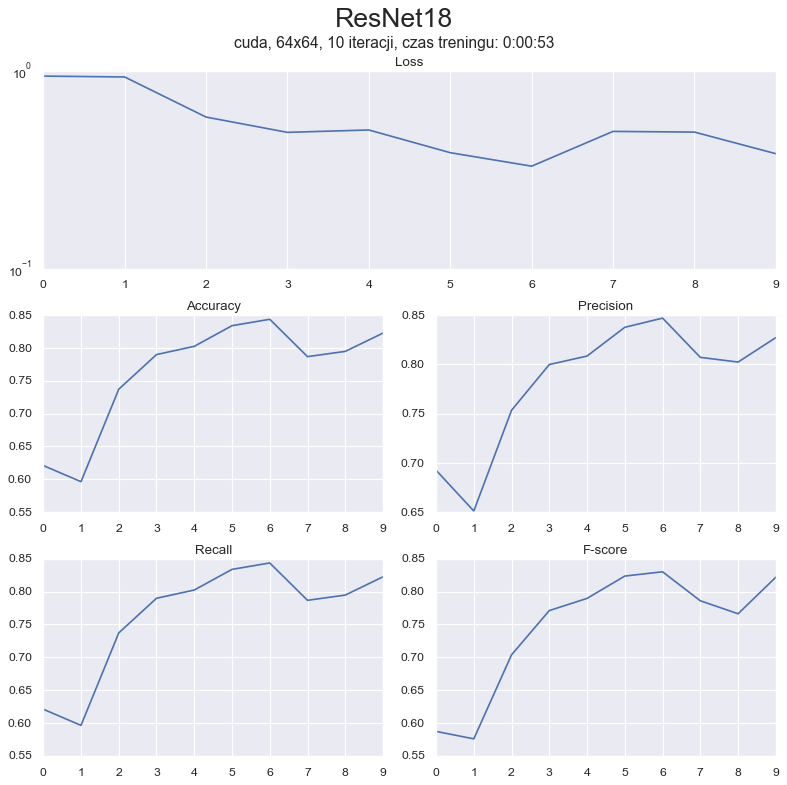

In [21]:
# TODO: More iterations
conduct_experiment("ResNet18", resnet_model, 10, torch.optim.Adam(resnet_model.parameters()))